# Image-to-image generation using OpenVINO GenAI

Image-to-image is the task of transforming an input image through a variety of possible manipulations and enhancements, such as super-resolution, image inpainting, colorization, stylization and more.

One of the most popular use cases of image-to-image is style transfer. With style transfer models:
  * a regular photo can be transformed into a variety of artistic styles or genres, such as a watercolor painting, a comic book illustration and more.
  * new images can be generated using a text prompt, in the style of a reference input image.
  
Latent diffusion models can be used for performing image-to-image generation. Diffusion-based Image-to-image is similar to [text-to-image](../text-to-image-genai/text-to-image-genai.ipynb), but in addition to a prompt, you can also pass an initial image as a starting point for the diffusion process. The initial image is encoded to latent space and noise is added to it. Then the latent diffusion model takes a prompt and the noisy latent image, predicts the added noise, and removes the predicted noise from the initial latent image to get the new latent image. Lastly, a decoder decodes the new latent image back into an image.

![pipe.png](https://user-images.githubusercontent.com/29454499/260981188-c112dd0a-5752-4515-adca-8b09bea5d14a.png)

In this tutorial, we consider how to use OpenVINO GenAI for performing image-to-image generation.

## About OpenVINO GenAI

[OpenVINO™ GenAI](https://github.com/openvinotoolkit/openvino.genai) is a library of the most popular Generative AI model pipelines, optimized execution methods, and samples that run on top of highly performant OpenVINO Runtime.

This library is friendly to PC and laptop execution, and optimized for resource consumption. It requires no external dependencies to run generative models as it already includes all the core functionality (e.g. tokenization via openvino-tokenizers).

OpenVINO GenAI supports popular diffusion models like Stable Diffusion or SDXL for performing image generation. You can find supported models list in [OpenVINO GenAI documentation](https://github.com/openvinotoolkit/openvino.genai/blob/master/SUPPORTED_MODELS.md#image-generation-models). Previously, we considered how to run [text-to-image](../text-to-image-genai/text-to-image-genai.ipynb) generation with OpenVINO GenAI and [apply multiple LoRA adapters](../multilora-image-generation/multilora-image-generation.ipynb), now is image-to-image turn. 

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Prepare model](#Prepare-model)
    - [Export OpenVINO IR format model using the Hugging Face Optimum library accelerated by OpenVINO integration.](#Export-OpenVINO-IR-format-model-using-the-Hugging-Face-Optimum-library-accelerated-by-OpenVINO-integration.)
    - [Use optimized models provided on HuggingFace Hub](#Use-optimized-models-provided-on-HuggingFace-Hub)
- [Create inference pipeline](#Create-inference-pipeline)
- [Prepare inputs](#Prepare-inputs)
- [Run inference pipeline](#Run-inference-pipeline)
- [Configure pipeline parameters](#Configure-pipeline-parameters)
    - [Strength](#Strength)
    - [Guidance scale](#Guidance-scale)
    - [Negative prompt](#Negative-prompt)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/image-to-image-genai/image-to-image-genai.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import platform
import requests
from pathlib import Path


%pip install -q "git+https://github.com/huggingface/optimum-intel.git" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q -U "openvino>=2025.0" "openvino-tokenizers>=2025.0" "openvino-genai>=2025.0"
%pip install -q Pillow "diffusers>=0.30.3" "gradio>=4.19" "typing_extensions>=4.9" "tqdm" huggingface-hub "nncf>=2.14.0" --extra-index-url https://download.pytorch.org/whl/cpu
if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

if not Path("cmd_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py",
    )
    open("cmd_helper.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("image-to-image-genai.ipynb")

## Prepare model
[back to top ⬆️](#Table-of-contents:)

For starting working with OpenVINO GenAI pipelines, we should prepare models for inference. OpenVINO GenAI image generation pipelines accepts diffusers-compatible models converted to OpenVINO Intermediate Representation format using Optimum Intel Interface. 

### Export OpenVINO IR format model using the [Hugging Face Optimum](https://huggingface.co/docs/optimum/installation) library accelerated by OpenVINO integration.
[back to top ⬆️](#Table-of-contents:)

🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 [Transformers](https://huggingface.co/docs/transformers/index) and [Diffusers](https://huggingface.co/docs/diffusers/index) libraries and OpenVINO to accelerate end-to-end pipelines on Intel architectures. It provides ease-to-use cli interface for exporting models to [OpenVINO Intermediate Representation (IR)](https://docs.openvino.ai/2024/documentation/openvino-ir-format.html) format.

The command bellow demonstrates basic command for model export with `optimum-cli`

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <out_dir>
```

where `--model` argument is model id from HuggingFace Hub or local directory with model (saved using `.save_pretrained` method), `--task ` is one of [supported task](https://huggingface.co/docs/optimum/exporters/task_manager) that exported model should solve. For image generation models, `text-to-image` or `image-to-image` should be used (as pipeline components are the same, you can use converted models for both text-to-image and image-to-image generation. There is no need to convert models twice). If model initialization requires to use remote code, `--trust-remote-code` flag additionally should be passed.
You can also apply fp16, 8-bit or 4-bit weight compression on the Linear, Convolutional and Embedding layers when exporting your model with the CLI by setting `--weight-format` to respectively fp16, int8 or int4. This type of optimization allows to reduce the memory footprint and inference latency.

We will use `optimum_cli` from our helper `cmd_helper.py` that is a wrapper over cli-command.

### Use optimized models provided on HuggingFace Hub
[back to top ⬆️](#Table-of-contents:)

For quick start, OpenVINO provides [collection](https://huggingface.co/collections/OpenVINO/image-generation-67697d9952fb1eee4a252aa8) of optimized models that are ready to use with OpenVINO GenAI. You can download them using following command:

```bash
huggingface-cli download <model_id> --local-dir <output_dir>
```

In [2]:
import ipywidgets as widgets

use_preconverted = widgets.Checkbox(value=True, description="Use preconverted", disabled=False)

use_preconverted

Checkbox(value=True, description='Use preconverted')

In [3]:
from pathlib import Path

from cmd_helper import optimum_cli

ov_model_id = "OpenVINO/stable-diffusion-v1-5-int8-ov"
hf_model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
model_dir = Path("stable-diffusion-v1-5-int8-ov")


if not model_dir.exists():
    if use_preconverted.value:
        !huggingface-cli download {ov_model_id} --local-dir {model_dir}
    else:
        optimum_cli(hf_model_id, model_dir, additional_args={"weight-format": "int8"})

## Create inference pipeline
[back to top ⬆️](#Table-of-contents:)

For creation Image-to-Image generation pipeline `openvino_genai.Image2ImagePipeline` should be used. The pipeline accepts directory with converted model and inference device.
Let's select execution device:

In [4]:
from notebook_utils import device_widget


device = device_widget("CPU", exclude=["NPU", "AUTO"])
device

/home/ea/work/py311/lib/python3.11/site-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(


Dropdown(description='Device:', options=('CPU',), value='CPU')

In [5]:
import openvino_genai as ov_genai

pipe = ov_genai.Image2ImagePipeline(model_dir, device.value)

## Prepare inputs
[back to top ⬆️](#Table-of-contents:)

The main inputs for image-to-image generation are input text prompt and image. Input prompt is represented by text string that contains user's instructions for pipeline guidance. Input image should be provided as `ov.Tensor`. The code bellow demonstrates how to convert image after reading Pillow library to OpenVINO tensor. You also can pass some additional advanced options for better controlling generation process. We consider the most useful from them in next sections.

In [6]:
import openvino as ov
import numpy as np
from PIL import Image


def image_to_tensor(image: Image) -> ov.Tensor:
    pic = image.convert("RGB")
    image_data = np.array(pic.getdata()).reshape(1, pic.size[1], pic.size[0], 3).astype(np.uint8)
    return ov.Tensor(image_data)

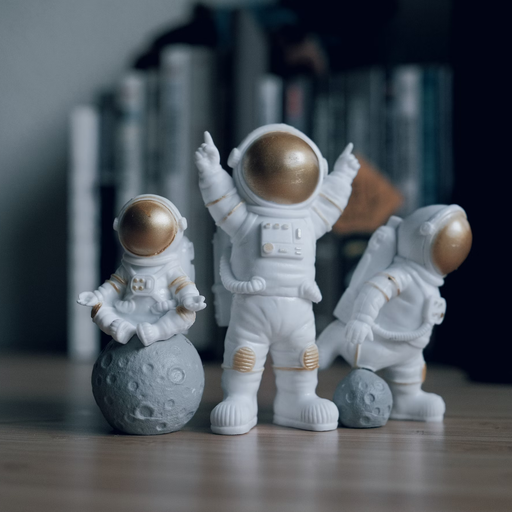

In [7]:
from PIL import Image
from diffusers.utils import load_image

init_image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/img2img-init.png"
init_image_path = Path("astronauts.png")

if not init_image_path.exists():
    image = load_image(init_image_url)
    image.save(init_image_path)

init_image = Image.open(init_image_path)
init_image_tensor = image_to_tensor(init_image)

init_image

## Run inference pipeline
[back to top ⬆️](#Table-of-contents:)

For starting generation process, `generate` method should be used. Together with input prompt and image, we also provided `generator`, pseudo-random numbers generator that responsible for results reproducibility. We will use `ov_genai.TorchGenerator` helper, the behavior of this generator is aligned with PyTorch. It means you can get result as much close to original diffusion pipeline as possible. `callback` argument allows early stopping generation if we decided that we are satisfied generation results when `num_inference_steps` has not been not reached yet, but it also can be useful for some other cases as well. In this tutorial, we will use it for adding interactive progress bar.

  0%|          | 0/31 [00:00<?, ?it/s]

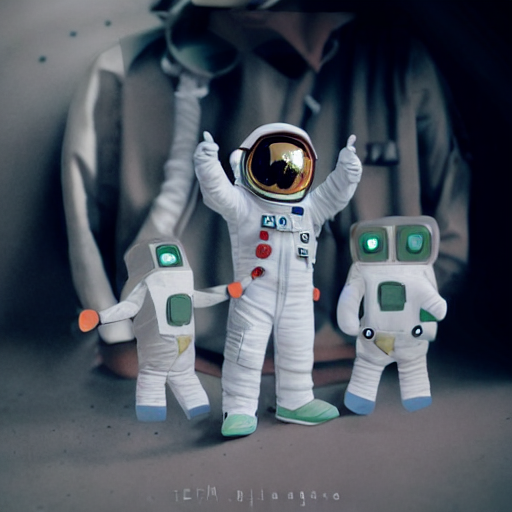

In [8]:
from tqdm.notebook import tqdm
import sys

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
random_generator = ov_genai.TorchGenerator(42)

pbar = tqdm(total=31)


def callback(step, num_steps, latent):
    pbar.update(1)
    sys.stdout.flush()
    return False


image_tensor = pipe.generate(prompt, init_image_tensor, callback=callback, generator=random_generator, strength=0.6)

pbar.close()

out_image = Image.fromarray(image_tensor.data[0])
out_image

## Configure pipeline parameters
[back to top ⬆️](#Table-of-contents:)

There are several important parameters you can configure in the pipeline that’ll affect the image generation process and image quality. Let’s take a closer look at what these parameters do and how changing them affects the output.

### Strength
[back to top ⬆️](#Table-of-contents:)

`strength` is one of the most important parameters to consider and it’ll have a huge impact on your generated image. It determines how much the generated image resembles the initial image. In other words:
* 📈 a higher strength value gives the model more “creativity” to generate an image that’s different from the initial image; a strength value of 1.0 means the initial image is more or less ignored
* 📉 a lower strength value means the generated image is more similar to the initial image

The `strength` and `num_inference_steps` parameters are related because strength determines the number of noise steps to add. For example, if the num_inference_steps is 50 and strength is 0.8, then this means adding 40 (50 * 0.8) steps of noise to the initial image and then denoising for 40 steps to get the newly generated image.

![](https://github.com/user-attachments/assets/73f818f6-f2e7-45c8-8f57-a64b3ea17870)

### Guidance scale
[back to top ⬆️](#Table-of-contents:)

The `guidance_scale` parameter is used to control how closely aligned the generated image and text prompt are. A higher `guidance_scale` value means your generated image is more aligned with the prompt, while a lower `guidance_scale` value means your generated image has more space to deviate from the prompt.

You can combine `guidance_scale` with `strength` for even more precise control over how expressive the model is. For example, combine a high `strength` + `guidance_scale` for maximum creativity or use a combination of low `strength` and low `guidance_scale` to generate an image that resembles the initial image but is not as strictly bound to the prompt.

![guidance_scale](https://github.com/user-attachments/assets/19b96e0b-5036-4957-8808-135cb2579161)


### Negative prompt
[back to top ⬆️](#Table-of-contents:)

A negative prompt conditions the model to not include things in an image, and it can be used to improve image quality or modify an image. For example, you can improve image quality by including negative prompts like “poor details” or “blurry” to encourage the model to generate a higher quality image. Or you can modify an image by specifying things to exclude from an image.


Let's try to apply these parameters for making pencil drawing to realistic photo.

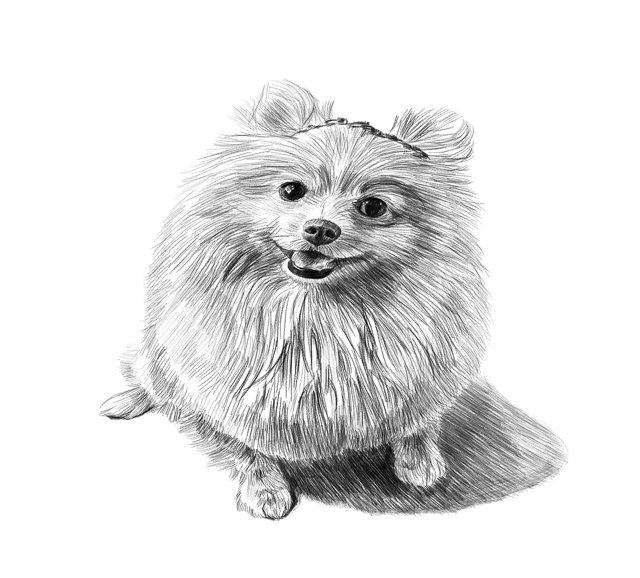

In [9]:
input_image_path = Path("dog_drawing.png")

if not input_image_path.exists():
    image = load_image("https://github.com/user-attachments/assets/501f88f6-97d9-4a48-8c6e-603fbee15a5b").resize((640, 578))
    image.save(input_image_path)

init_image = Image.open(input_image_path)
init_image

  0%|          | 0/16 [00:00<?, ?it/s]

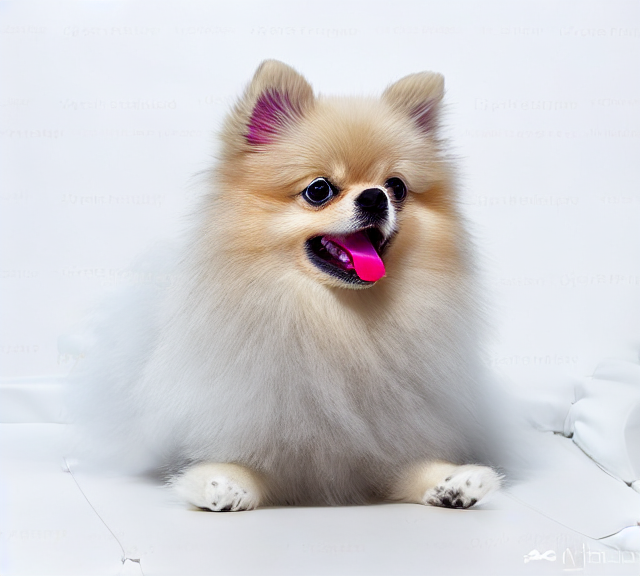

In [10]:
import math

strength = 0.75

num_inference_steps = 20

random_generator = ov_genai.TorchGenerator(426)

prompt = "professional photo of pomeranian spitz, bright realistic colours, highly detailed, hyper realistic, bright cinematic lighting, gopro"
negative_prompt = "blurry, poor quality, low res, worst quality, cropped, ugly, nude, naked, grayscale"

pbar = tqdm(total=math.ceil((num_inference_steps + 1) * strength))

init_image_tensor = image_to_tensor(init_image)


def callback(step, num_steps, latent):
    pbar.update(1)
    sys.stdout.flush()
    return False


image_tensor = pipe.generate(
    prompt,
    init_image_tensor,
    negative_prompt=negative_prompt,
    strength=strength,
    num_inference_steps=20,
    num_images_per_prompt=1,
    generator=random_generator,
    callback=callback,
)

pbar.close()

out_image = Image.fromarray(image_tensor.data[0])
out_image

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [11]:
if not Path("gradio_helper.py").exists():
    r = requests.get("https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/image-to-image-genai/gradio_helper.py")

    with open("gradio_helper.py", "w") as f:
        f.write(r.text)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(pipe, ov_genai.TorchGenerator, image_to_tensor)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/